# Real Estate Predictor

---

As is described in the README, this project focuses on the goals of a hypothetical real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the property to its resale, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

This project uses the [Ames housing data on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Credit to <a href="https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset">Julien Cohen Solal</a> for some of the EDA techniques and other visualizations I used in this project.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Part 1: Estimating the value of homes from fixed characteristics.

---
The goal of this part is to build a reliable estimator for the sale price of the house given characteristics that cannot be changed or would require a "major" renovation. Some examples include:
- The neighborhood
- Square footage
- Number of bedrooms

Some examples of things that are renovate-able:
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything personally deemed modifiable without having to undergo major construction on the house.

---

### Steps to be completed for Part 1:
1. Remove any houses from the dataset that are not residential.
1. Perform any cleaning, feature engineering, and EDA deemed necessary.
1. Identify **fixed** features that can predict price.
1. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.  
    (Note: this is a project assignment specification, and random splitting of the dataset will be explored in next steps for this project.)
1. Characterize the model. How well does it perform? What are the best estimates of price?


In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

### 1. Remove any houses from the dataset that are not residential.

In [3]:
house = house.loc[house['MSZoning'].map(lambda x: 'R' in x)]
house.shape

(1385, 81)

### 2. Perform any cleaning, feature engineering, and EDA you deem necessary.

In [4]:
house.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
76,77,20,RL,NaN,8475,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,135750
1300,1301,60,RL,NaN,10762,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,225000
278,279,20,RL,107.0,14450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,New,Partial,415298


**Note:** I will make Id the index for the dataframe. This way if new data is added later, I can match on Id.

In [5]:
# check that there are no duplicate Id's
len(house.Id.unique())

1385

In [6]:
# make Id column the index
house.set_index('Id', inplace=True)
house.sample(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1194,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
882,50,RL,44.0,13758,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,187500
890,20,RL,128.0,12160,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,149500


In [7]:
# preliminary check of datatypes and missing data
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1134 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            65 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-

In [8]:
# returns columns with null values in descending order
def missing_values(df):
    missing = pd.DataFrame(df.isnull().sum(), columns=['Nulls'])
    missing['PercentNull'] = missing.Nulls / df.isnull().count() 
    return missing.sort_values(by='Nulls', ascending=False)

In [9]:
# look at the null value percentage for top 20 columns
missing = missing_values(house)
missing.head(20)

,Nulls,PercentNull
PoolQC,1378,0.994946
MiscFeature,1333,0.962455
Alley,1320,0.953069
Fence,1108,0.800000
FireplaceQu,641,0.462816
LotFrontage,251,0.181227
GarageYrBlt,79,0.057040
GarageCond,79,0.057040
GarageType,79,0.057040
GarageFinish,79,0.057040


#### Notes:  
- Of the columns with at least 15% of the data missing, I'm going to drop PoolQC (only 7 houses with pools and still have PoolArea), MiscFeature (only 54 homes with it and still have MiscVal), Alley, FireplaceQu (still have number of fireplaces), and LotFrontage. Fence is going to have the NA's recoded to NF for No Fence.
- For Electrical, MasVnrArea, MasVnrType, I'll just drop the rows where this value is missing since it's less than 1% of the data.
- The others need a little more investigation. I'll start with a correlation matrix for the numerical variables and box plots for the categorical ones.

In [10]:
# recode the nulls in Fence to reflect No Fence
house['Fence'] = house['Fence'].fillna('NF')

In [12]:
# drop the columns with more than 15% null entries
missing = missing_values(house)
house = house.drop(missing[missing['PercentNull'] > .15].index,1)

In [13]:
# drop the row where Electrical is null
house = house.drop(house.loc[house['Electrical'].isnull()].index)

In [14]:
# drop the rows where MasVnrArea or MasVnrType is null
mask = (house['MasVnrArea'].isnull()) | (house['MasVnrType'].isnull())
house = house.drop(house.loc[mask].index)
house.shape

(1379, 75)

**Note:**  
Maybe YearBuilt and GarageYrBlt are so strongly correlated that we can get away with only considering YearBuilt, since that doesn't have any nulls. I'll explore that here.

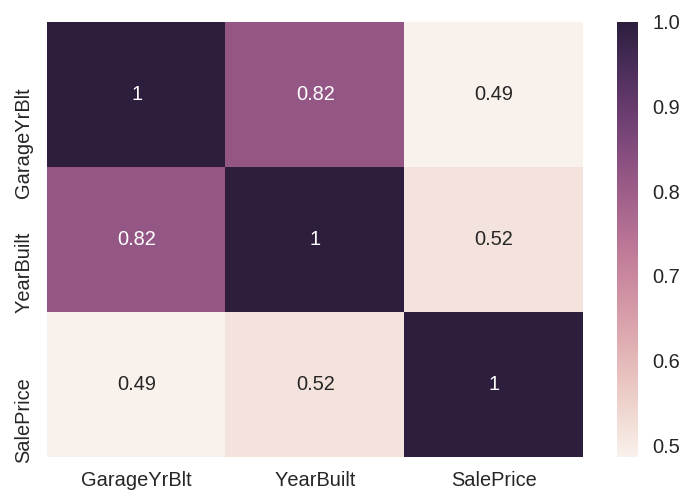

In [15]:
# look at correlation
sns.heatmap(house[['GarageYrBlt','YearBuilt','SalePrice']].corr(), annot=True)

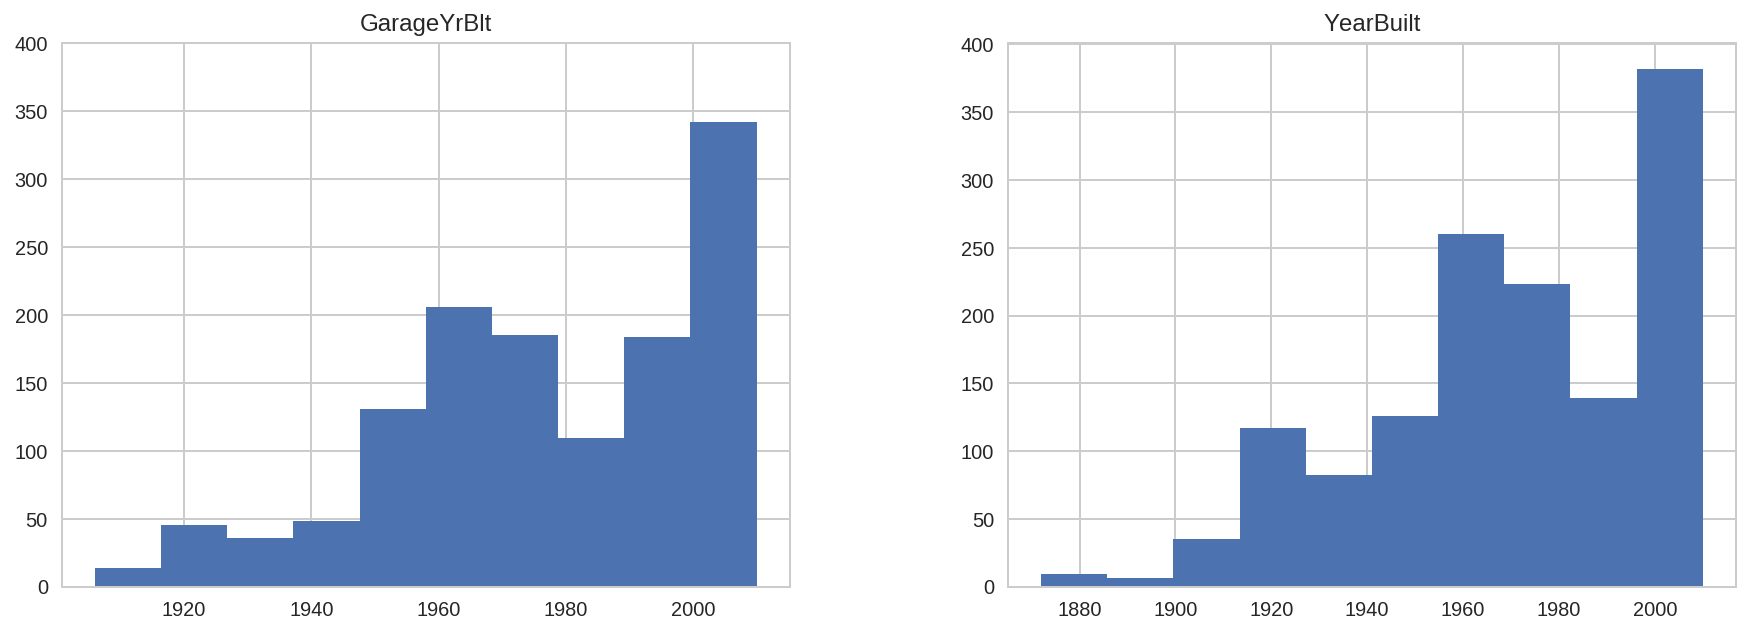

In [16]:
# graph the distributions
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
house[['GarageYrBlt']].hist(ax=ax1)
ax1.set_ylim(top=400)
house[['YearBuilt']].hist(ax=ax2)
plt.show()

In [17]:
# identify number of garages built after the house was built
sum(house['YearBuilt'] < house['GarageYrBlt'])

270

**Note:**  
Based on similarities in distributions and such a small percentage of garages built after the house, I'm comfortable dropping the GarageYrBlt column from the data.

In [18]:
house = house.drop('GarageYrBlt', axis=1)

In [19]:
# assign names of categorical columns to investigate
cat_cols = ['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2',
            'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']

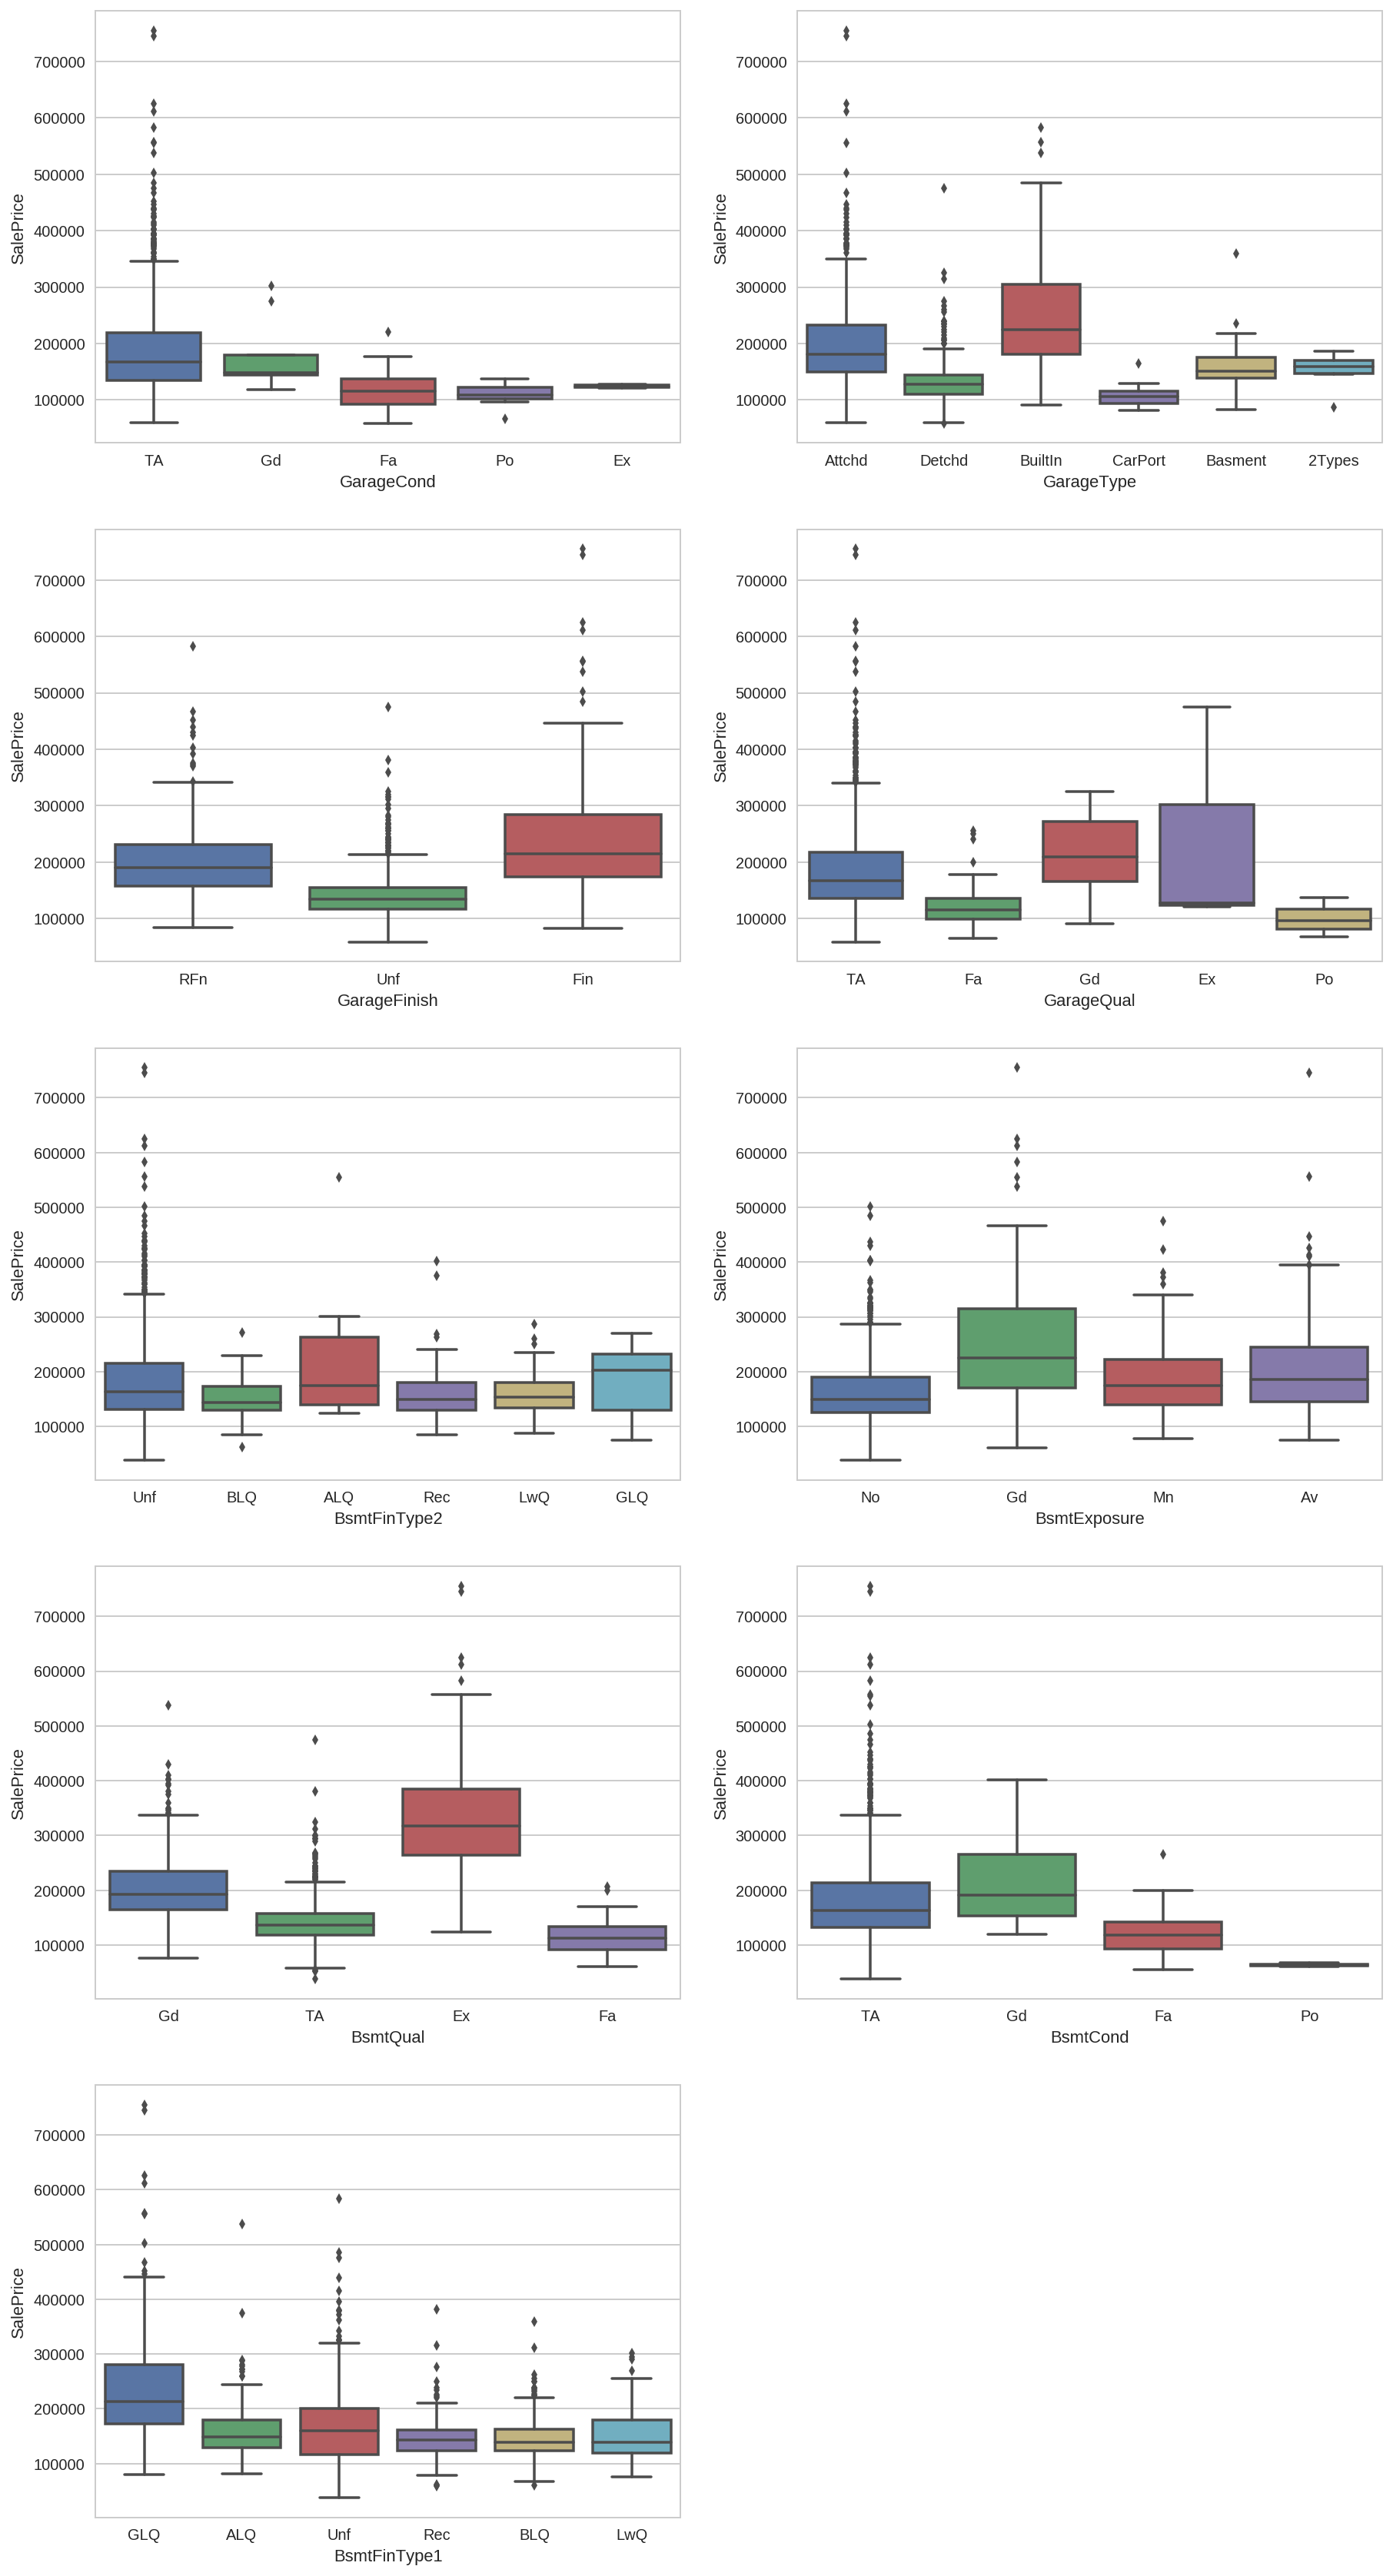

In [20]:
# create boxplots
fig = plt.figure(figsize=(15,30))
for i,col in enumerate(cat_cols):
    fig.add_subplot(521+i)
    sns.boxplot(x=col, y='SalePrice',data=house) 

**Note:**  
These columns seem to contain a significant number of outliers. With Garage info, there is still size in car capacity and size in square feet with complete data, so I'm okay dropping the Garage features plotted above. Regarding Basement info, the null values are an indication of no basement, so I'm going to fill them with 'NB' for No Basement. Many of these appear to have an influence on price, so I do not want to simply drop them.

In [21]:
house = house.drop(['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'], axis=1)

In [22]:
# recode the basement nulls
cat_cols = ['BsmtFinType2','BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in cat_cols:
    house[col] = house[col].fillna('NB')

In [23]:
# check to see if all missing values have been accounted for.
missing_values(house).head(2)

,Nulls,PercentNull
MSSubClass,0,0.0
BsmtFullBath,0,0.0


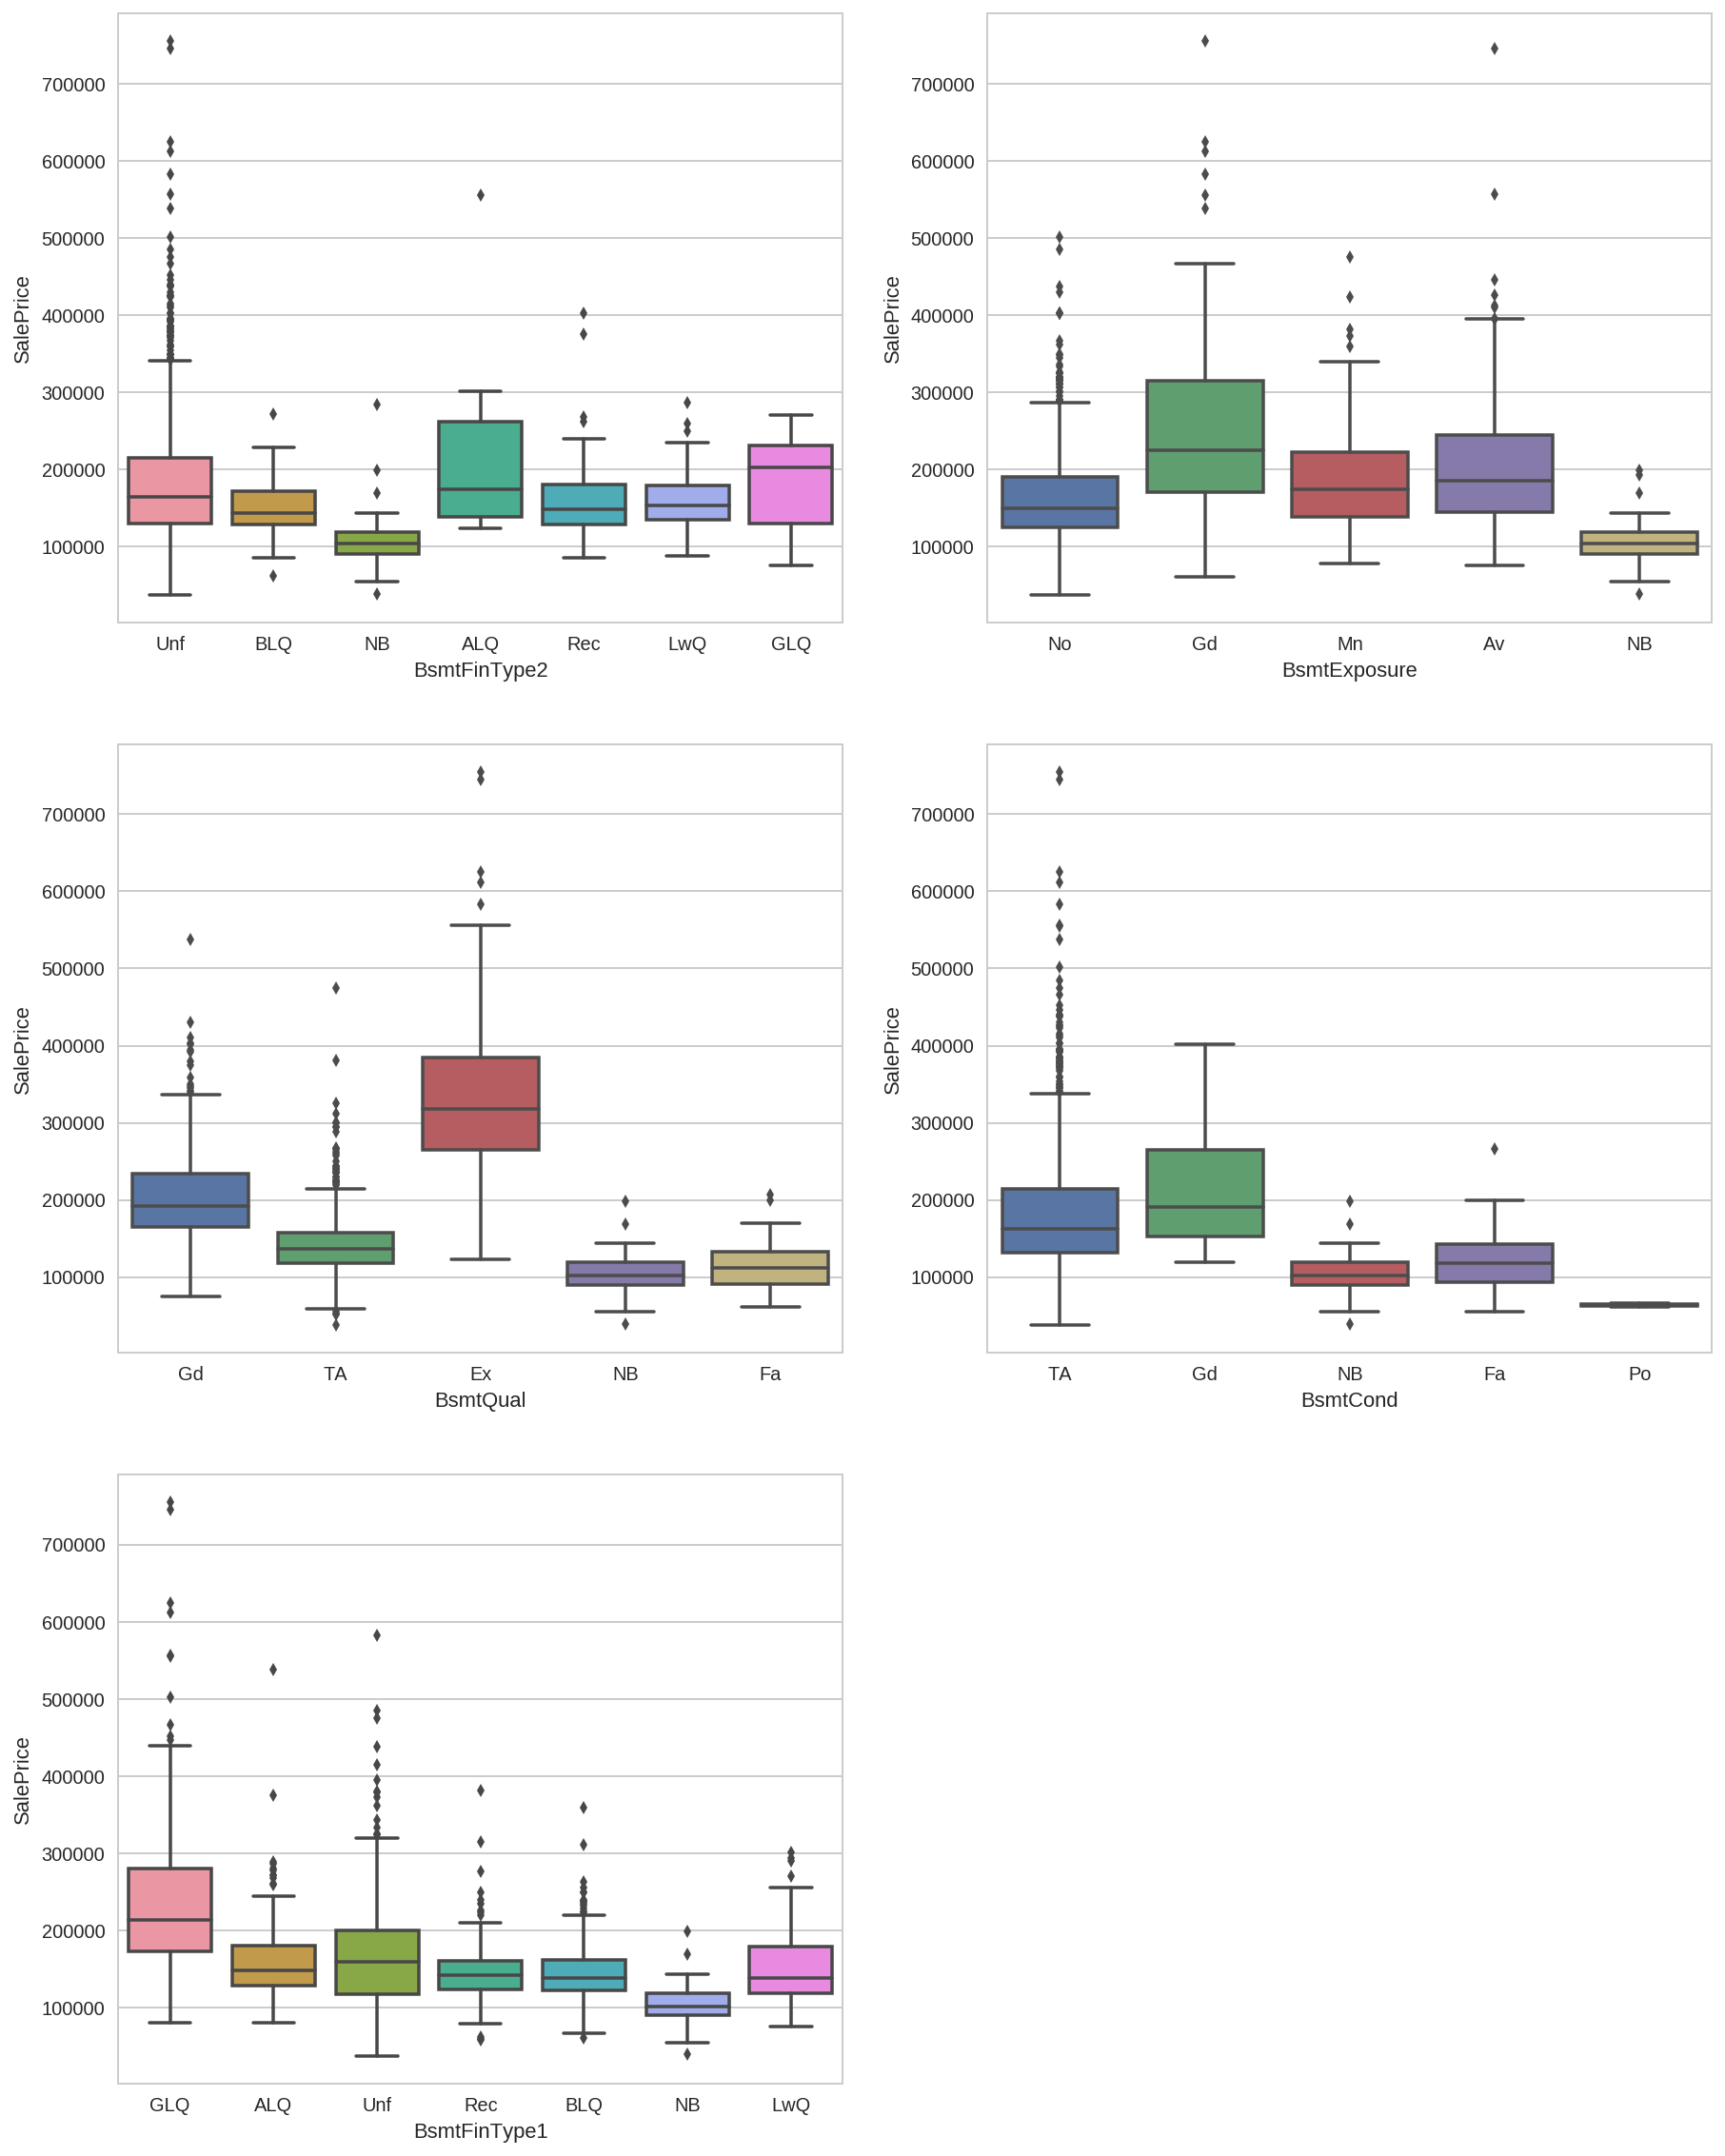

In [24]:
# look at basement box plots again now that nulls are gone
fig = plt.figure(figsize=(15,20))
for i,col in enumerate(cat_cols):
    fig.add_subplot(321+i)
    sns.boxplot(x=col, y='SalePrice',data=house)

**Note:**  
It appears that the absence of a basement does have an impact on sale price since in most of the cases above, the NB column appears to have the lowest average sale price in the group.

### Outliers  
In an effort to identify any outliers, let's look at some pair plots of SalePrice and the other numerical features.

In [25]:
# make separate column lists for categorical and numeric
categorical = [col for col in house.columns if house.dtypes[col] == 'object']
numeric = [col for col in house.columns if house.dtypes[col] != 'object']

# remove SalePrice from the list since it's the target and everything will be plotted against it
numeric.remove('SalePrice')

In [26]:
# check to make sure none were
1 + len(numeric) + len(categorical) == house.shape[1]

True

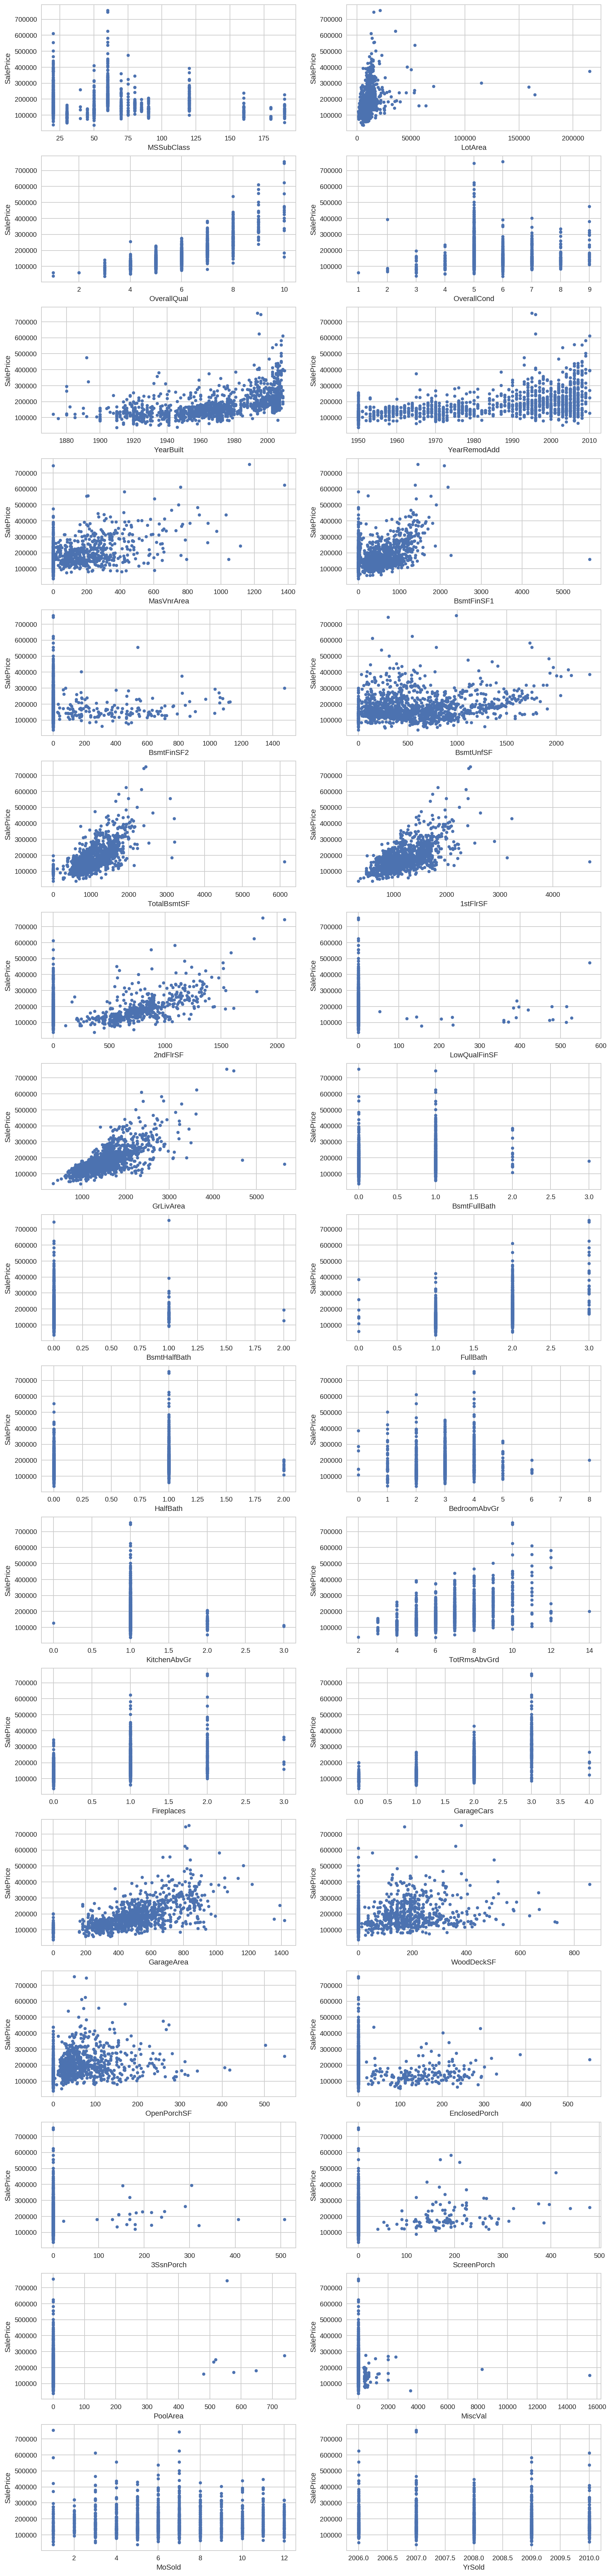

In [27]:
# graph each numerical column against SalePrice
fig, axes = plt.subplots(int(np.ceil(len(numeric)/2.0)), 2, figsize=(15,70))
for i,col in enumerate(numeric):
    house.plot.scatter(x=col, y='SalePrice', ax=axes[i//2,i%2])
plt.show()

**Note:**  
There are four properties above 4000 square feet (GrLivArea), and two of them seem to not follow the trend. I'm going to break up the numeric features into two types: continuous and discrete. The discrete will be treated as categorical for purpose of visualization (box plots) while the continuous will be explored further to identify outliers using the Tukey Method.

In [28]:
# printing for easier copying and pasting in next step
print(numeric)

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [29]:
# split numeric features into two sets
continuous = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
              'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
              'PoolArea', 'MiscVal']
discrete = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
            'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
            'MoSold', 'YrSold']

In [30]:
# check that none were missed
1+len(categorical)+len(continuous)+len(discrete) == house.shape[1]

True

In [31]:
# function that uses the Tukey method to identify outliers
def identify_outliers(dataframe, col):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = 1.5*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

In [32]:
# function to cleanly display the number of outliers for each feature
def display_outliers(df,cols):
    outlier_dict = {}
    for col in cols:
        out_df = identify_outliers(df,col)
        outlier_dict[col] = out_df.shape[0]
    return pd.DataFrame(list(outlier_dict.items()),
                        columns=['feature','total_outliers']).sort_values('total_outliers', ascending=False)

**Note:**  
Here is the number of outliers for each continuous feature. Next I'll account for the rows that are outliers in multiple features.

In [33]:
display_outliers(house,continuous)

,feature,total_outliers
13,EnclosedPorch,201
3,BsmtFinSF2,167
15,ScreenPorch,114
1,MasVnrArea,84
12,OpenPorchSF,73
0,LotArea,71
5,TotalBsmtSF,60
17,MiscVal,50
11,WoodDeckSF,31
9,GrLivArea,31


In [34]:
# this creates a list of indices for all outliers, including duplicates.
raw_outliers = []
for col in continuous:
    outlier_df = identify_outliers(house, col)
    raw_outliers += list(outlier_df.index)

In [35]:
# compare the total number of outliers to just the unique ones and total rows
print('Total outliers:', len(raw_outliers))
print('Unique outliers:', len(set(raw_outliers)))
print('Total rows:', house.shape[0])

Total outliers: 1004
Unique outliers: 683
Total rows: 1379


**Note:**  
Because nearly half of the rows in the data contain outliers, it doesn't make sense to me to remove them. Most of the literature I found on this data does suggest removing the two homes that are really large but have a low sale price. For the rest, at least for the numerical columns, I will check their skew and log transform those that are significantly skewed. 

In [36]:
# find and remove the two homes that are very large but have low sale price
mask = (house['GrLivArea'] > 4000) & (house['SalePrice'] < 300000)
house = house.drop(house.loc[mask].index)
house.shape

(1377, 70)

In [37]:
from scipy.stats import skew

In [38]:
# calculate skew of each numerical column (including SalePrice) and identify those greater than .75
skewed_features = house[numeric+['SalePrice']].apply(lambda x: skew(x))
skewed_features = skewed_features[abs(skewed_features) > .75]
print(str(skewed_features.shape[0]) + ' skewed numerical columns will be log transformed.')
skewed_features = skewed_features.index
print(skewed_features.get_values())

21 skewed numerical columns will be log transformed.
['MSSubClass' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtHalfBath' 'HalfBath'
 'KitchenAbvGr' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'SalePrice']


In [39]:
# transform the skewed features identified above
house[skewed_features] = np.log1p(house[skewed_features])

**Note:**  
Let's look at the distribution of a few of the transformed features to see the effects of the transformation.

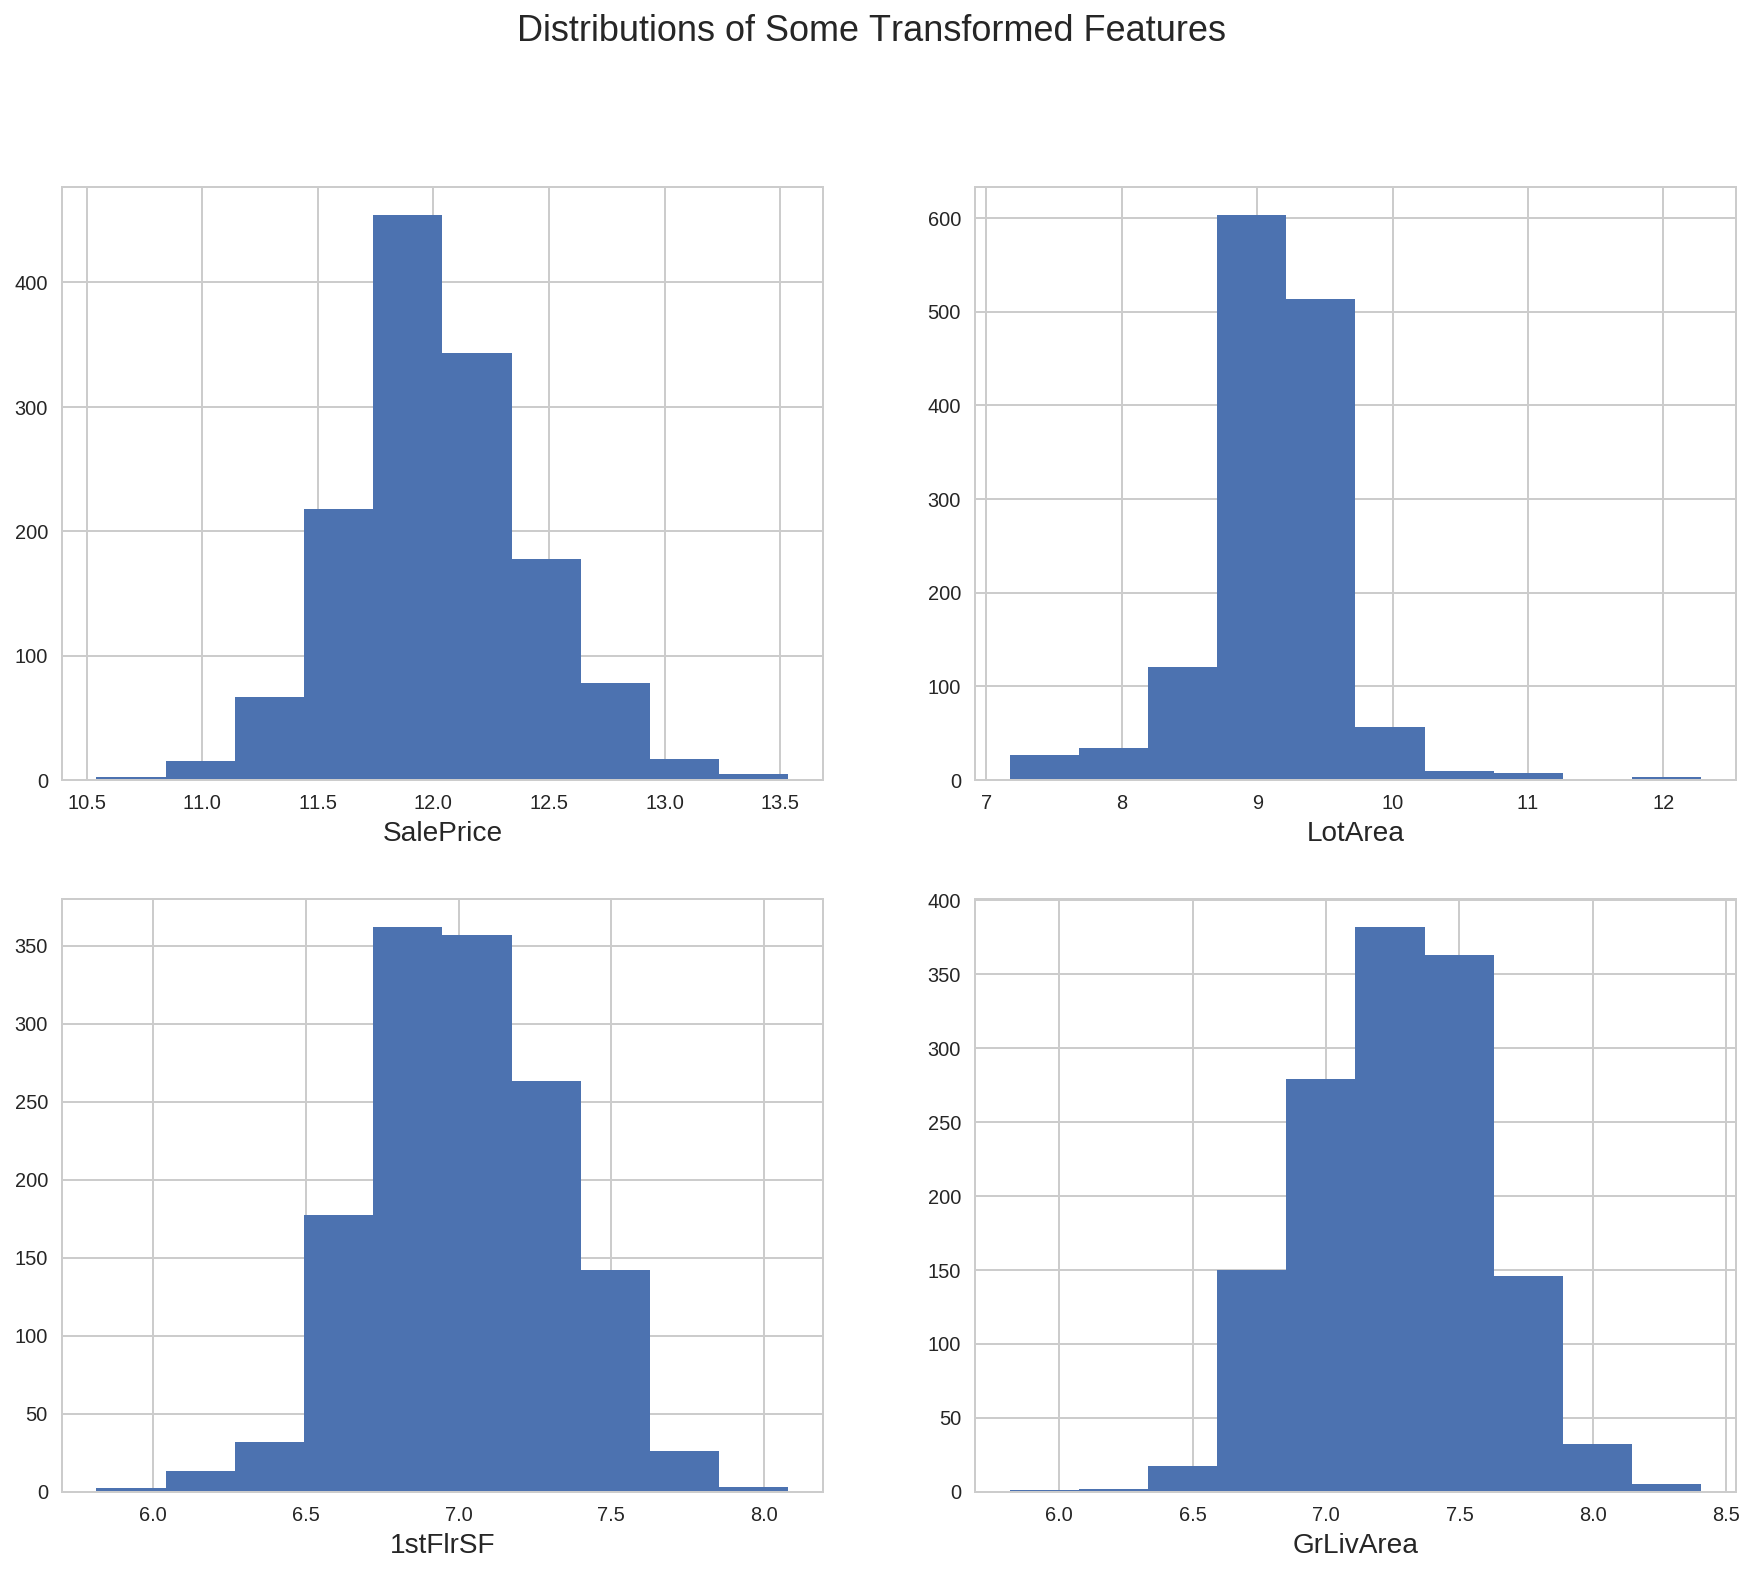

In [45]:
cols = ['SalePrice', 'LotArea', '1stFlrSF', 'GrLivArea']
fig = plt.figure(figsize=(15, len(cols)*3)) 
plt.suptitle('Distributions of Some Transformed Features', fontsize=18)
for i,col in enumerate(cols):
    ax = fig.add_subplot(221 + i)
    house[col].hist()
    ax.set_xlabel(col, fontsize=14)

**Note:**  
The graphs confirm that the log transformation has made the data less skewed, and it will reduce the affect of outliers.

### 3. Identify fixed features that can predict price.

In [47]:
# creating my lists of fixed features and fixable features
fixed_features = ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
                  'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
                  'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
fixable_features = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtFinType1', 'BsmtFinType2',
                    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'FullBath', 'HalfBath',
                    'KitchenQual', 'Functional', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence',  'MiscVal',]

In [48]:
# check that no features were missed (other than SalePrice)
1 + len(fixed_features) + len(fixable_features) == house.shape[1]

True

### 4. Train a model on pre-2010 houses and evaluate its performance on the 2010 houses.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [50]:
# create dataframe consisting of only fixed features
house_fixed = house.loc[:,fixed_features]

In [51]:
# convert all the categorical features to booleans
house_fixed = pd.get_dummies(house_fixed)
house_fixed.shape

(1377, 140)

In [52]:
# create masks to split training data from test data
train_mask = house['YrSold'] < 2010
test_mask = house['YrSold'] == 2010

In [53]:
# get the training set and check the sizes
X_train = house_fixed.loc[train_mask]
y_train = house.loc[train_mask].SalePrice
X_train.shape, y_train.shape

((1214, 140), (1214,))

In [54]:
# get the test set and check the sizes
X_test = house_fixed.loc[test_mask]
y_test = house.loc[test_mask].SalePrice
X_test.shape, y_test.shape

((163, 140), (163,))

### Lasso Regression
I will loop through Lasso models in order to tune the alpha parameter.

In [60]:
from sklearn.linear_model import Lasso

In [61]:
results = []
for a in np.arange(0.00035, 0.00046, 0.00001):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    results.append({'alpha':a,
                    'train_score':lasso.score(X_train, y_train), 
                    'test_score':lasso.score(X_test, y_test)})
pd.DataFrame(results).T

,0,1,2,3,4,5,6,7,8,9,10
alpha,0.000350,0.000360,0.000370,0.000380,0.000390,0.000400,0.000410,0.000420,0.000430,0.000440,0.000450
test_score,0.905595,0.905623,0.905649,0.905667,0.905681,0.905692,0.905698,0.905698,0.905694,0.905678,0.905646
train_score,0.898471,0.898292,0.898109,0.897928,0.897743,0.897554,0.897372,0.897240,0.897104,0.896968,0.896831


**Note:**  
Based on the above table, it looks like alpha = 0.00041 or 0.00042 provides the best test score. This model performs better than the linear regression model, and I suspect it has done so with fewer features. Let's look at the coefficients and confirm that.

In [62]:
# fit the Lasso with alpha = 0.00041
lasso = Lasso(alpha=0.00041)
lasso.fit(X_train, y_train)

Lasso(alpha=0.00041, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

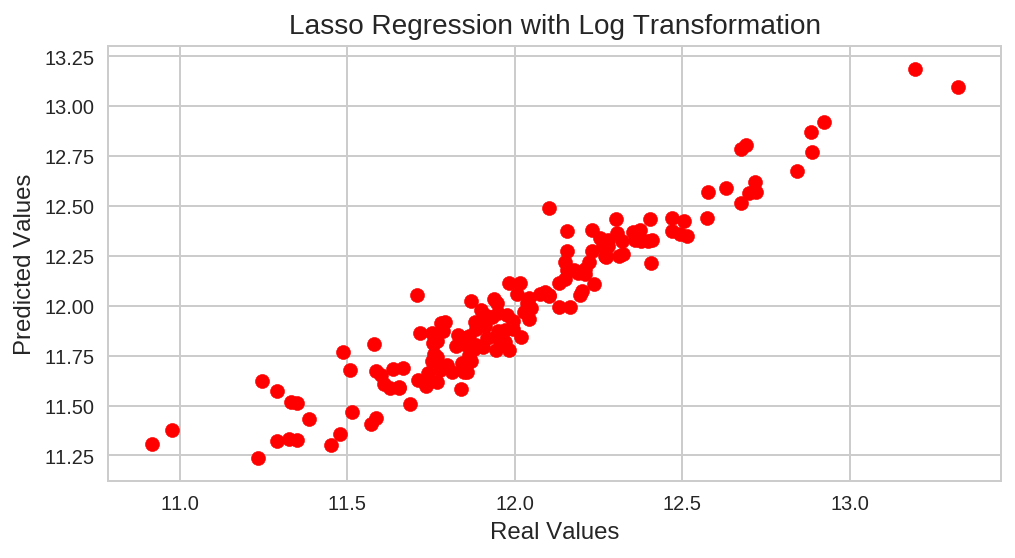

In [66]:
# scatter plot of actual values vs predicted values
y_test_pred = lasso.predict(X_test)
fig = plt.figure(figsize=(8,4))
plt.title('Lasso Regression with Log Transformation', fontsize=14)
plt.scatter(y_test, y_test_pred, c = 'red')
plt.xlabel('Real Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.show()

In [67]:
# look at which features were eliminated
coefs_lasso = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso eliminated {} of the {} original features.".format(sum(coefs_lasso == 0), len(coefs_lasso)))
print('Eliminated:', coefs_lasso[coefs_lasso == 0].index.get_values())

Lasso eliminated 70 of the 140 original features.
Eliminated: ['MSSubClass' '1stFlrSF' 'MSZoning_RH' 'MSZoning_RL' 'Street_Grvl'
 'Street_Pave' 'LotShape_IR1' 'LotShape_IR3' 'LandContour_Bnk'
 'LandContour_HLS' 'LandContour_Lvl' 'Utilities_AllPub' 'Utilities_NoSeWa'
 'LotConfig_FR3' 'LandSlope_Mod' 'Neighborhood_Blmngtn'
 'Neighborhood_Blueste' 'Neighborhood_BrDale' 'Neighborhood_ClearCr'
 'Neighborhood_CollgCr' 'Neighborhood_IDOTRR' 'Neighborhood_NPkVill'
 'Neighborhood_SWISU' 'Neighborhood_SawyerW' 'Neighborhood_Timber'
 'Condition1_Feedr' 'Condition1_PosA' 'Condition1_PosN' 'Condition1_RRAn'
 'Condition1_RRNe' 'Condition1_RRNn' 'Condition2_Artery' 'Condition2_Feedr'
 'Condition2_Norm' 'Condition2_PosA' 'Condition2_PosN' 'Condition2_RRAe'
 'Condition2_RRAn' 'Condition2_RRNn' 'BldgType_2fmCon' 'BldgType_Twnhs'
 'HouseStyle_1Story' 'HouseStyle_2.5Fin' 'HouseStyle_2.5Unf'
 'HouseStyle_SLvl' 'RoofStyle_Flat' 'RoofStyle_Gambrel' 'RoofStyle_Hip'
 'RoofStyle_Mansard' 'RoofStyle_Shed' 'Found

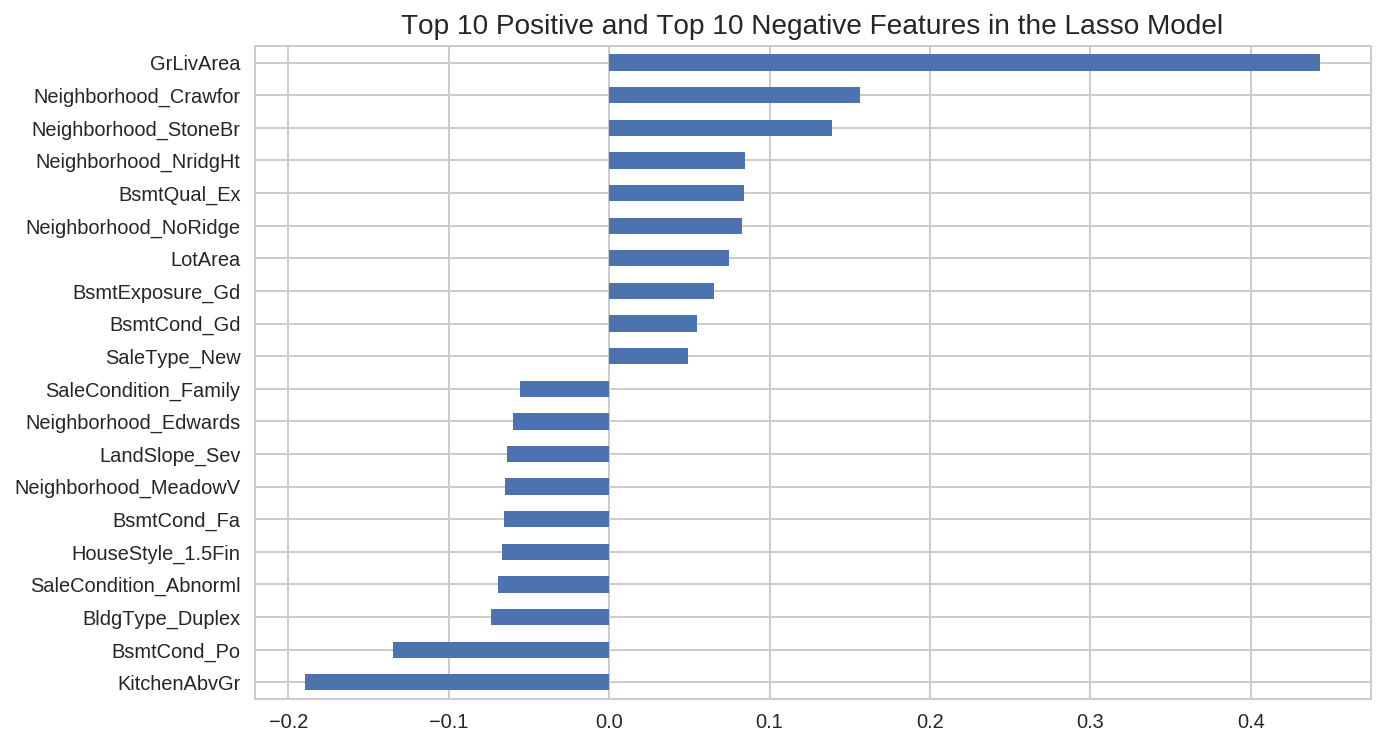

In [68]:
# look at the features that impact the model the most
top20_coefs_lasso = pd.concat([coefs_lasso.sort_values(ascending=True).head(10),
                        coefs_lasso.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(10,6))
top20_coefs_lasso.plot(kind = "barh")
plt.title("Top 10 Positive and Top 10 Negative Features in the Lasso Model", fontsize=14)
plt.show()

**Note:**  
The Lasso identified GrLivArea as top positive contributor and identified 3 top neighborhoods. It also identified KitchenAbvGr and BsmtCond_Po (poor basement) as the biggest detractors from sale price. While I'm pleased with the Lasso model score, for the sake of comparison I'm going to try a RandomForest model now.

### RandomForest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [83]:
# create pipeline for scaling and fitting
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regr', RandomForestRegressor())
])

# list of hyperparameters to tune
rf_params = {
    'regr__n_estimators': [125, 150, 175],
    'regr__max_features': ['auto', 'log2']
}

rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5, n_jobs=-1)

In [84]:
# fit the model and check the results
rf_gs.fit(X_train, y_train)
print(rf_gs.score(X_train, y_train))
print(rf_gs.score(X_test, y_test))
rf_gs.best_params_

0.981244951697
0.882079991555


{'regr__max_features': 'auto', 'regr__n_estimators': 175}

**Note:**  
Now that I have the best parameters, I fit the model again to see which features this model listed as most important. Even though the score is slightly less than the Lasso, I'm still curious to see the features.

In [85]:
rf = RandomForestRegressor(n_estimators=175)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=175, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

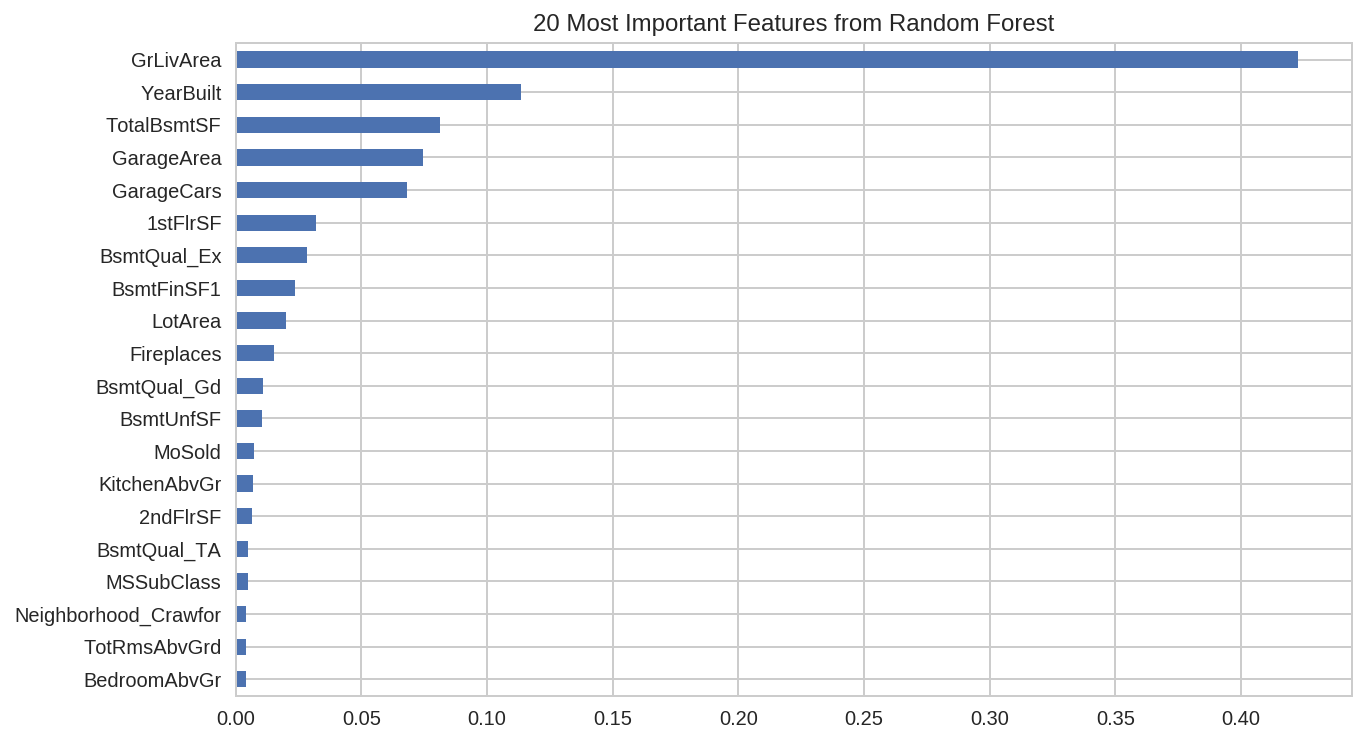

In [89]:
# look at most influential features for the random forest model
rf_feats = pd.Series(rf.feature_importances_, index = X_train.columns)
fig = plt.figure(figsize=(10,6))
rf_feats.sort_values().tail(20).plot(kind='barh')
plt.title('20 Most Important Features from Random Forest')
plt.show()

**Note:**  
The random forest model comes up a little shy in score comparison to the Lasso. What is reassuring is that GrLivArea is yet again at the top of the list as the most important feature. 

### 5. Characterize your model. How well does it perform? What are the best estimates of price?

**Answer:**  
The model that performed the best was the Lasso. Not only does it provide the best test score, but it also uses fewer features than the other models I tried.

As you can see in the graph below, the best estimators of price according to my model are GrLivArea (above ground living area), Neighborhood_Crawfor (Crawford Neighborhood), Neighborhood_StoneBr (Stone Bridge Neighborhood), BsmtCond_Po (severe cracking, settling or wetness in the basement), and KitchenAbvGr (number of kitchens above gound level). The first three influence price positively and the last two have negative influence. Overall, the following neighborhoods seem to have a positive impact on price: Crawford, Stone Brook, Northridge Heights. Meadow Village is the neighborhood that appears to most negatively impact sale price.

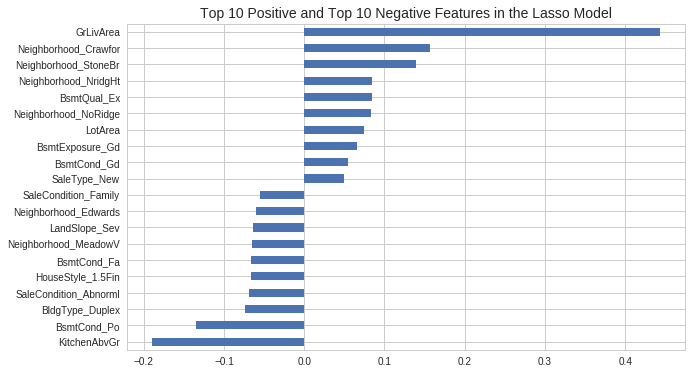

In [69]:
fig = plt.figure(figsize=(10,6))
top20_coefs_lasso.plot(kind = "barh")
plt.title("Top 10 Positive and Top 10 Negative Features in the Lasso Model", fontsize=14)
plt.show()

### Results Metrics

In [71]:
# get predictions from the lasso model
predictions = lasso.predict(X_test_log)

In [73]:
# create a dataframe with actual prices and predicted prices
results_df = pd.DataFrame({'actual_log_price': y_test_log, 'predicted_log_price':predictions})
results_df.head()

,actual_log_price,predicted_log_price
16,11.911708,11.896522
24,11.944714,11.778022
26,11.811555,11.668044
27,12.631344,12.590888
33,12.016733,12.115882


In [76]:
# convert the transformed prices back to non-transformed values
results_df['actual_price'] = results_df.actual_log_price.apply(lambda x: int(np.expm1(x)))
results_df['predicted_price'] = results_df.predicted_log_price.apply(lambda x: int(round(np.expm1(x),0)))
results_df.head()

,actual_log_price,predicted_log_price,actual_price,predicted_price
16,11.911708,11.896522,149000,146754
24,11.944714,11.778022,153999,130355
26,11.811555,11.668044,134800,116779
27,12.631344,12.590888,305999,293868
33,12.016733,12.115882,165499,182750


**Metric:**  
On many housing price predictors, mean absolute percent error (MAPE) appears to be the favored metric. This metric measures the absolute difference between actual and predicted as a percentage for each house and then returns the average.

$$ MAPE = \frac{100}{n}\sum_{k=1}^n\left|\frac{Actual_k - Predicted_k}{Actual_k}\right| $$

In [77]:
# calculate the MAPE for non-transformed prices
np.mean(np.abs((results_df.actual_price - results_df.predicted_price) / results_df.actual_price)) * 100

9.3155513719388594

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

**Step 1.** Get fixable_categorical, fixable_continuous, fixable_discrete in case I need them later.

In [66]:
# for purpose of EDA, split fixable features into various categories
fixable_categorical = [col for col in house_log[fixable_features].columns if house_log.dtypes[col] == 'object']
fixable_numeric = [col for col in house_log[fixable_features].columns if house_log.dtypes[col] != 'object']
print(fixable_numeric)

['OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'LowQualFinSF', 'FullBath', 'HalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [67]:
fixable_discrete = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'FullBath', 'HalfBath']

fixable_continuous = ['MasVnrArea', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [68]:
# check to make sure I got them all
len(fixable_features), len(fixable_categorical), len(fixable_numeric), \
len(fixable_discrete), len(fixable_continuous)

(30, 16, 14, 5, 9)

**Step 2.** Get predictions using previous model. Calculate residuals and add that column to the log-transformed dataframe.

In [69]:
# make dummy variables for log-transformed fixed-feature data so that I can use previous linear model
X = pd.get_dummies(house_log[fixed_features])

In [70]:
# make predicted sale prices a series so indices match the data
y_pred = pd.Series(lasso.predict(X), index=X.index)
residuals = house_log['SalePrice'] - y_pred
house_log['residual'] = residuals

**Step 3.** Do some EDA with fixable features and residuals.

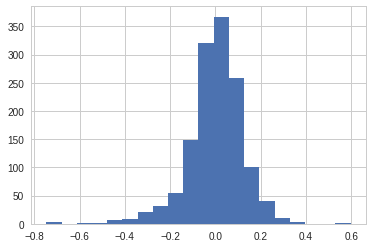

In [71]:
# check distribution of the target
house_log['residual'].hist(bins=20)

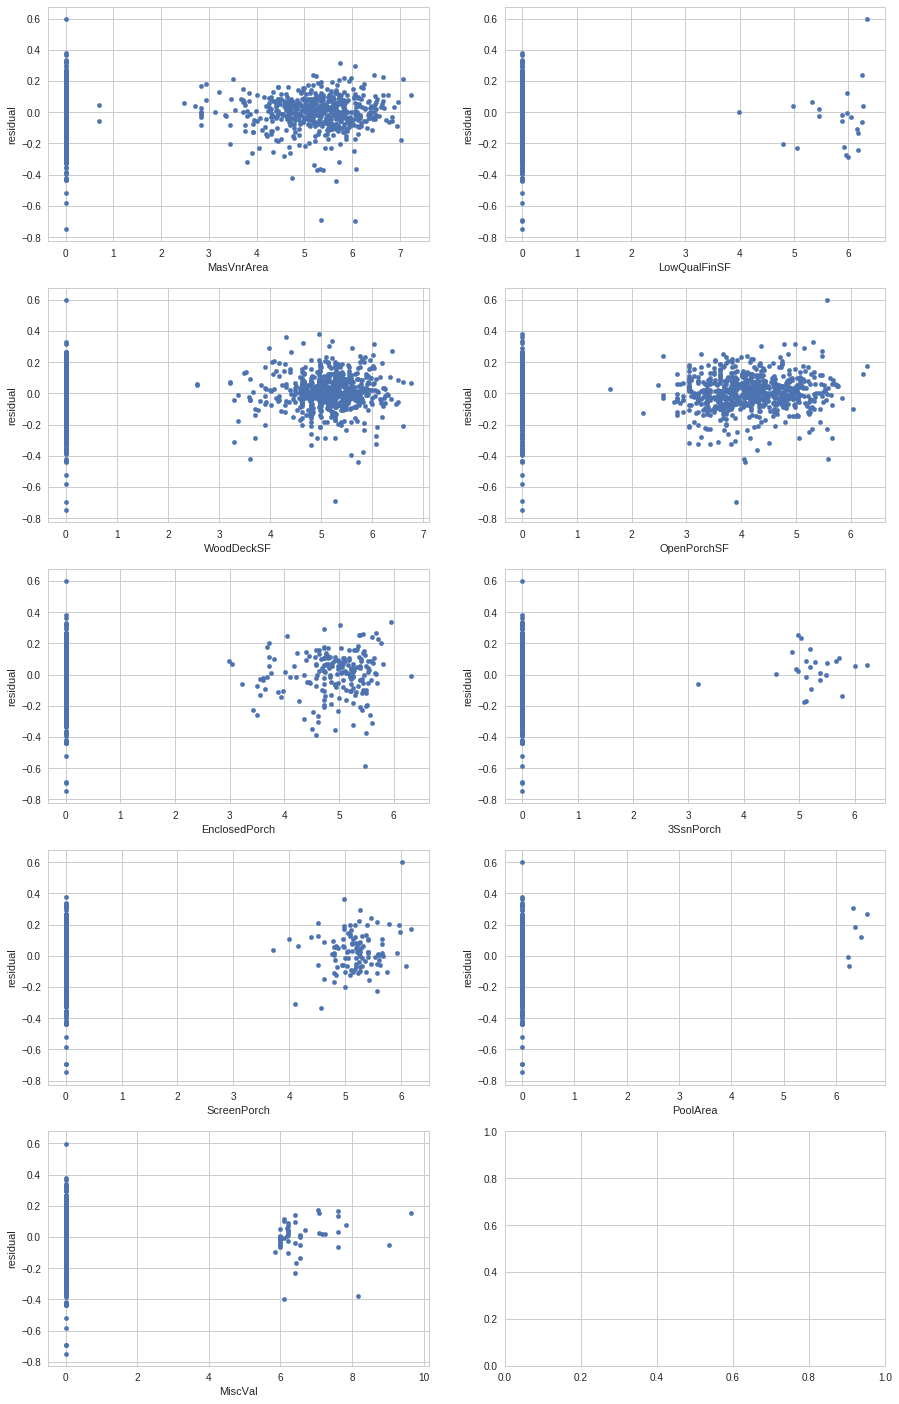

In [72]:
# pair plots of continuous fixable features and residuals
n_rows =int(np.ceil(len(fixable_continuous)/2.0))
fig, axes = plt.subplots(n_rows, 2, figsize=(15,5*n_rows))
for i,col in enumerate(fixable_continuous):
    house_log.plot.scatter(x=col, y='residual', ax=axes[i/2,i%2])
plt.show()

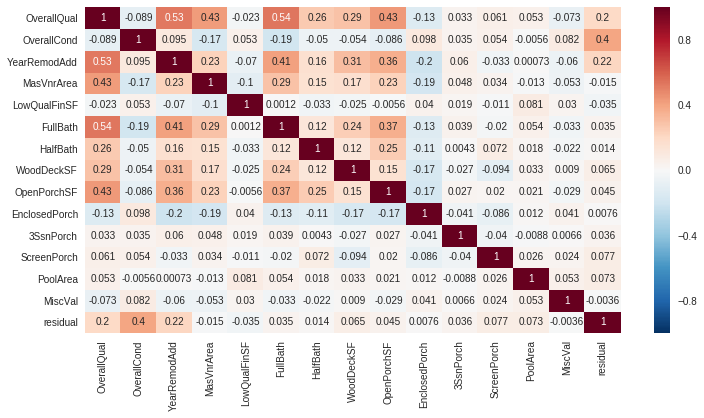

In [73]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(house_log[fixable_features+['residual']].corr(), annot=True)
plt.show()

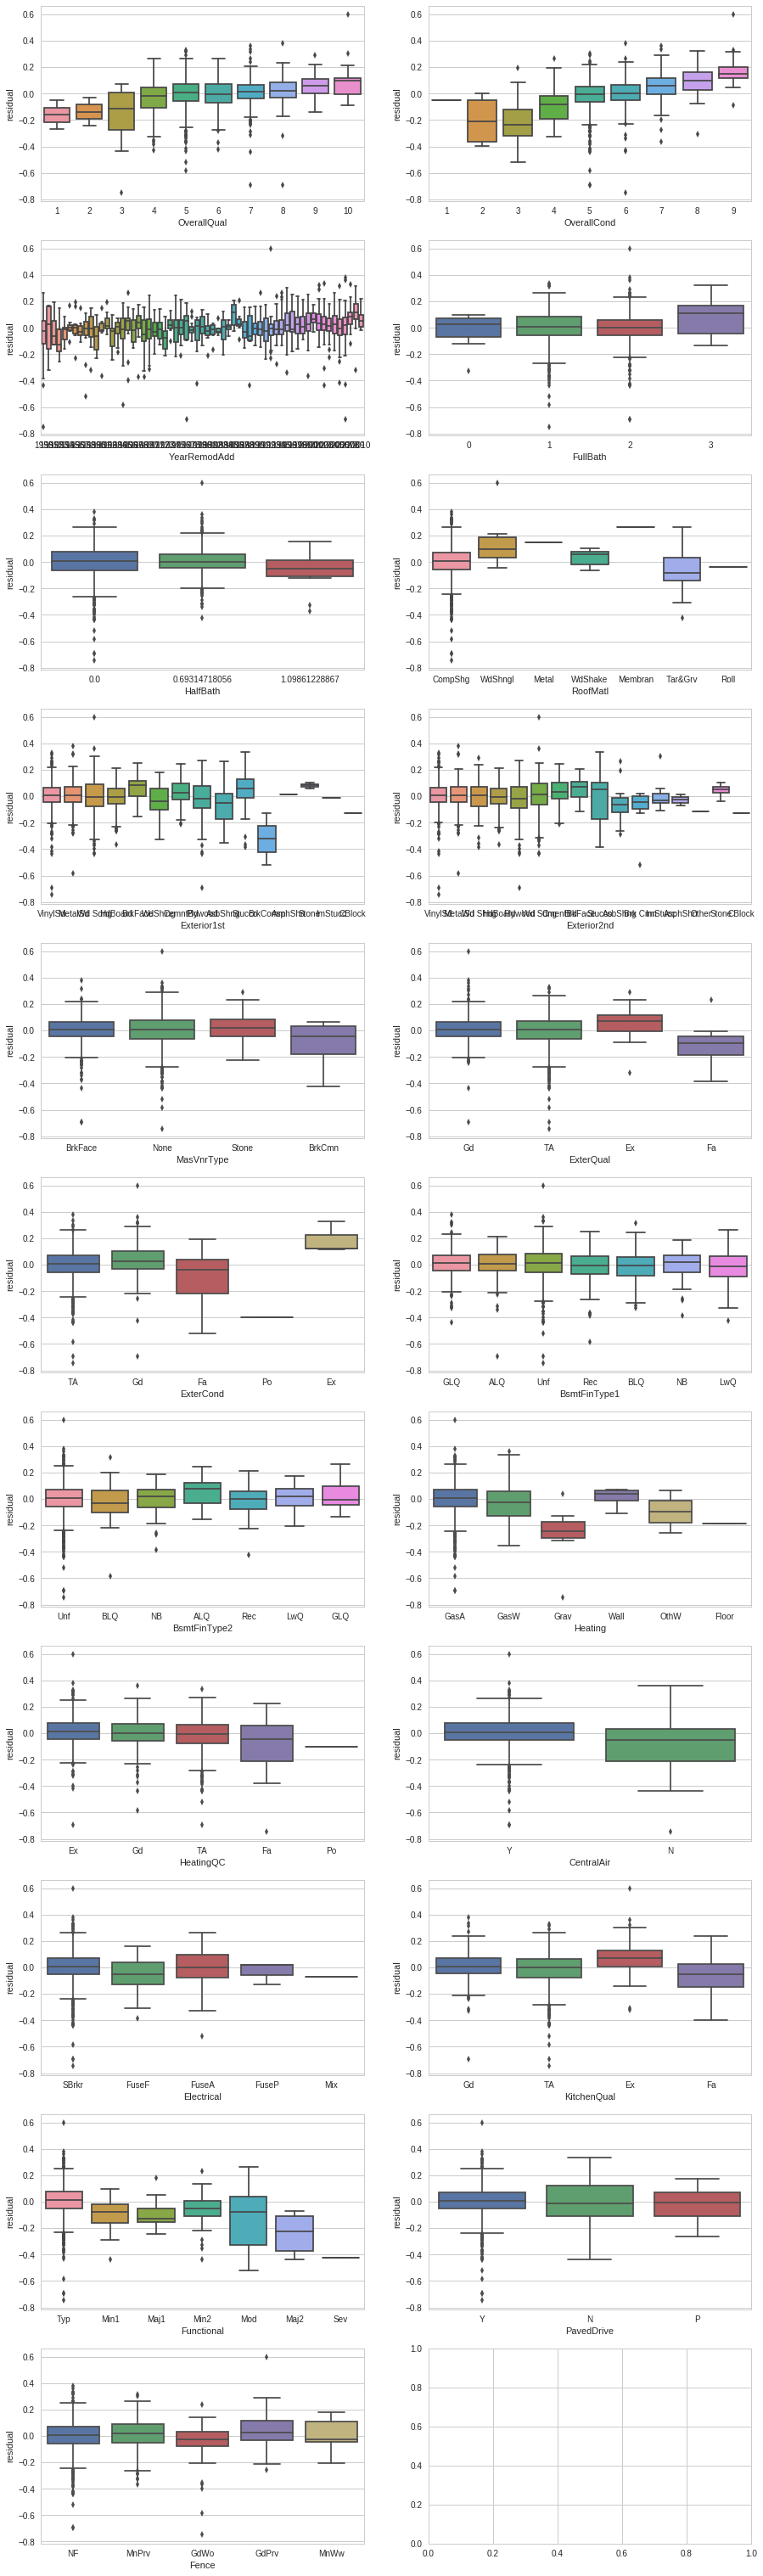

In [74]:
n_rows = int(np.ceil(len(fixable_discrete + fixable_categorical)/2.0))
fig, axes = plt.subplots(n_rows, 2, figsize=(15,5*n_rows))
for i,col in enumerate(fixable_discrete + fixable_categorical):
    sns.boxplot(x=col, y='residual',data=house_log, ax=axes[i/2,i%2])
plt.show()

**Note:**  
I don't really see any patterns in the data, except in OverallQual and OverallCond. With regard to these two features, it seems our SalePrice prediction model underpriced homes with high values in these features and overpriced those with low values. There seems to be no strong correlations to residual in the heatmap and the pair plots didn't reveal any apparent patterns. I don't believe a linear regression model is going to perform well, but that's where I'll start.

**Step 4.** Subset the data to just fixable columns and get dummy variables.

In [75]:
house_log_fixable = house_log.loc[:,fixable_features]
house_log_fixable.shape

(1377, 30)

In [76]:
# convert categorical columns to dummy variables
house_log_fixable = pd.get_dummies(house_log_fixable)
house_log_fixable.shape

(1377, 116)

**Step 5.** Split the data into train and test sets.

In [77]:
X_train_log = house_log_fixable.loc[train_mask]
y_train_log = house_log.residual[train_mask]
X_test_log = house_log_fixable.loc[test_mask]
y_test_log = house_log.residual[test_mask]
X_train_log.shape, y_train_log.shape, X_test_log.shape, y_test_log.shape

((1214, 116), (1214,), (163, 116), (163,))

**Step 6.** Fit models with residual as target.

#### Linear Regression

In [78]:
linreg_res = LinearRegression()

In [79]:
linreg_res.fit(X_train_log, y_train_log)
print(linreg_res.score(X_train_log, y_train_log))
print(linreg_res.score(X_test_log, y_test_log))

0.355592285047
0.2316997834


**Note:**  
Pretty low scores compared to the model to predict SalePrice from before. Let's look at the coefficients for this model before trying to fit a different one.

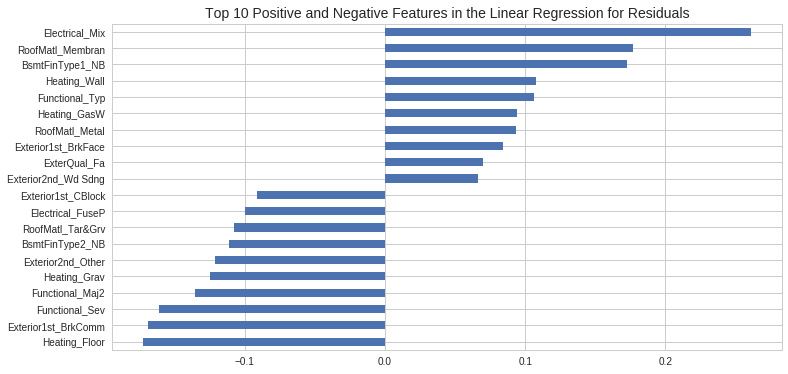

In [80]:
coefs_linreg_res = pd.Series(linreg_res.coef_, index = X_train_log.columns)
top20_coefs_linreg_res = pd.concat([coefs_linreg_res.sort_values(ascending=True).head(10),
                        coefs_linreg_res.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(12,6))
top20_coefs_linreg_res.plot(kind = "barh")
plt.title("Top 10 Positive and Negative Features in the Linear Regression for Residuals", fontsize=14)
plt.show()

#### Lasso
I'm gonna loop through to tune the alpha parameter.

In [81]:
results = []
for a in np.arange(0.0001, 0.0011, 0.0001):
    lasso_res = Lasso(alpha=a)
    lasso_res.fit(X_train_log, y_train_log)
    results.append({'alpha':a,
                    'train_score':lasso_res.score(X_train_log, y_train_log), 
                    'test_score':lasso_res.score(X_test_log, y_test_log)})
pd.DataFrame(results).T

,0,1,2,3,4,5,6,7,8,9
alpha,0.000100,0.000200,0.000300,0.000400,0.000500,0.000600,0.000700,0.000800,0.000900,0.001000
test_score,0.248995,0.254434,0.260317,0.263363,0.263357,0.259926,0.256407,0.253559,0.252580,0.251664
train_score,0.342747,0.327850,0.319210,0.310853,0.303795,0.296980,0.292317,0.288203,0.285432,0.282633


**Note:**  
It looks like alpha = 0.0005 gives the best test score. Let's take a look at the coefficients.

In [82]:
lasso_res = Lasso(alpha=0.0005)
lasso_res.fit(X_train_log, y_train_log)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso picked 45 features and eliminated 71 features


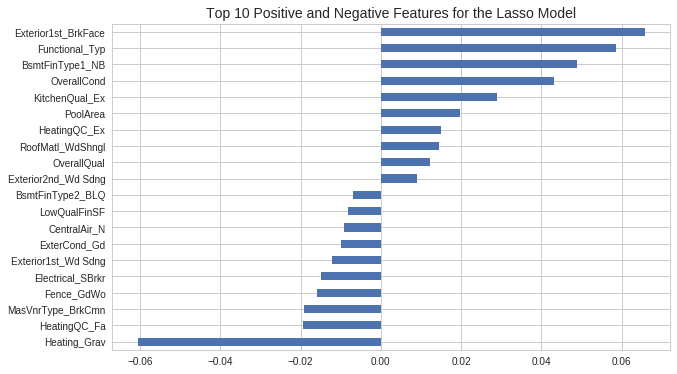

In [83]:
coefs_lasso_res = pd.Series(lasso_res.coef_, index = X_train_log.columns)
print("Lasso picked " + str(sum(coefs_lasso_res != 0)) + " features and eliminated " +
      str(sum(coefs_lasso_res == 0)) + " features")
top_coefs_lasso_res = pd.concat([coefs_lasso_res.sort_values(ascending=True).head(10),
                        coefs_lasso_res.sort_values(ascending=True).tail(10)])
fig = plt.figure(figsize=(10,6))
top_coefs_lasso_res.plot(kind = "barh")
plt.title("Top 10 Positive and Negative Features for the Lasso Model", fontsize=14)
plt.show()

**Summary:**  
Here's how I've interpreted these results. Admittedly, I haven’t been able to conceptualize this with specifics, so I’ll be sharing a broad overview. My first model can be used to predict the sale price of a home. My second model can explain about 26% of the variance in the difference between actual sale price and the price my first model predicts. Negative residuals in my first model indicate that it predicted a sale price higher than the actual sale price. My second model states that on average, we can recoup about 26% of that difference. The features in my second model that drive the residual down (thus meaning our predicted sale price is higher than actual) are those with negative coefficients.  For instance, looking at the chart above, gravity furnace heating, fair heating quality and condition, common brick veneer, fence with good wood, and standard circuit breaker electrical system are some of the features that cause my model to overvalue a home (negative residual). Finding homes with these features to be remodeled would lead to a profit on resale because it brings the value of the home closer to what my model predicted. This, of course, is assuming the renovation costs do not exceed the difference in value. I suspect my model can help calculate these numbers; however, I don’t exactly know how. This fact makes it difficult for me to assess the trustworthiness of my models. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

### My Attempted Solution

**Step 1:** Encode the SaleCondition column to 0 if not abnormal, 1 if it is abnormal.

In [84]:
# check how many abnormal sales there are
house_log.SaleCondition.value_counts()

Normal     1151
Partial     100
Abnorml      92
Family       20
Alloca       10
AdjLand       4
Name: SaleCondition, dtype: int64

In [85]:
# create function to do the encoding and check that the number is correct
house_log.SaleCondition.apply(lambda x: 1 if x == 'Abnorml' else 0).sum()

92

In [86]:
# replace the SaleCondition column with encoded values then check that it was done correctly
house_log['SaleCondition'] = house_log.SaleCondition.apply(lambda x: 1 if x == 'Abnorml' else 0)
house_log.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,residual
0,4.110874,RL,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.0,0.0,NF,0.0,2,2008,WD,0,12.247699,0.021609
1,3.044522,RL,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0.0,0.0,NF,0.0,5,2007,WD,0,12.109016,-0.011898
2,4.110874,RL,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0.0,0.0,NF,0.0,9,2008,WD,0,12.317171,0.009183
3,4.262680,RL,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0.0,0.0,NF,0.0,2,2006,WD,1,11.849405,-0.311260
4,4.110874,RL,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0.0,0.0,NF,0.0,12,2008,WD,0,12.429220,-0.170575


**Step 2:** Encode categorical columns and split data into train and test sets.

In [87]:
house_dummy = pd.get_dummies(house_log.drop('SaleCondition', axis=1))
X_train = house_dummy[train_mask]
y_train = house_log['SaleCondition'][train_mask]
X_test = house_dummy[test_mask]
y_test = house_log['SaleCondition'][test_mask]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1214, 252), (1214,), (163, 252), (163,))

In [88]:
y_train.sum(), y_test.sum()

(83, 9)

**Step 3:** Define a new scoring metric not based on accuracy.

In [89]:
# create a scorer that uses precision and recall
from sklearn.metrics import auc, make_scorer, precision_recall_curve
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score[:, 1])
    return auc(recall, precision, reorder=True)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True, needs_proba=True)

**Step 4:** Fit and score models.

In [90]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, classification_report

#### AdaBoost Classifier

In [91]:
ada_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=100))
])

ada_params = {
    'clf__learning_rate': [.4, .45, .5, .55, .6]
}

ada_gs = GridSearchCV(ada_pipe, ada_params, cv=5, scoring=pr_auc_scorer, n_jobs=-1)

In [92]:
ada_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_...om_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__learning_rate': [0.4, 0.45, 0.5, 0.55, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(pr_auc_score, needs_proba=True), verbose=0)

In [93]:
ada_gs.best_params_

{'clf__learning_rate': 0.55}

In [94]:
ada_gs.best_score_

0.31208970039936551

In [95]:
ada_gs.score(X_test,y_test)

0.29925017041581459

In [96]:
joblib.dump(ada_gs,'adaboost_gs.p')

['adaboost_gs.p']

In [97]:
ada_gs = joblib.load('./adaboost_gs.p')

In [98]:
ada_gs.score(X_test, y_test)

0.29925017041581459

In [99]:
confusion_matrix(y_test, ada_gs.predict(X_test))

array([[150,   4],
       [  7,   2]])

In [100]:
print(classification_report(y_test, ada_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96       154
          1       0.33      0.22      0.27         9

avg / total       0.92      0.93      0.93       163



**Note:**  
There are 9 abnormal sales in the test set. This model correctly identified only 2.

#### Gradient Boost

In [101]:
grad_pipe = ([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier())
])

grad_params = {
    'clf__learning_rate': [.1, .5, 1, 10],
    'clf__max_depth': [1, 3, 5]
}

grad_gs = GridSearchCV(grad_pipe, grad_params, cv=5, scoring=pr_auc_score, n_jobs=-1)

In [102]:
grad_gs.fit(X_train, y_train)

TypeError: estimator should be an estimator implementing 'fit' method, [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))] was passed

**Note:**  
I'm not sure what's going on with the error above. Isn't my estimator GradientBoostingClassifier and doesn't it implement a 'fit' method? 

In [103]:
gb = GradientBoostingClassifier(learning_rate=.1, max_depth=3, n_estimators=200)
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [104]:
confusion_matrix(y_test, gb.predict(X_test))

array([[152,   2],
       [  8,   1]])

In [106]:
print(classification_report(y_test, gb.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       154
          1       0.33      0.11      0.17         9

avg / total       0.92      0.94      0.92       163



**Note:** In the absence of my ability to use GridSearch with Gradient Boost, I cannot get better than the score I have above. That's unfortunate.